Import necessary libraries

In [7]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Embedding, Reshape, Concatenate, Flatten, Dropout
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU
from keras.utils import plot_model
from keras.optimizers import Adam

In [8]:
import numpy as np
print('Numpy Version :', np.__version__)

Numpy Version : 1.26.3


In [9]:
import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib Version :', matplotlib.__version__)
import graphviz
print('Graphviz Version :', graphviz.__version__)

Matplotlib Version : 3.8.2
Graphviz Version : 0.20.1


In [10]:
import os
import sys

In [7]:
main_dir=os.path.dirname(sys.path[0])
print('Main Directory :', main_dir)

Main Directory : /Users/revathiprasanna





Load Data

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 96s 8us/step


In [11]:
print("X_train Shape : ", X_train.shape)
print("y_train Shape : ", y_train.shape)

X_train Shape :  (60000, 28, 28)
y_train Shape :  (60000,)


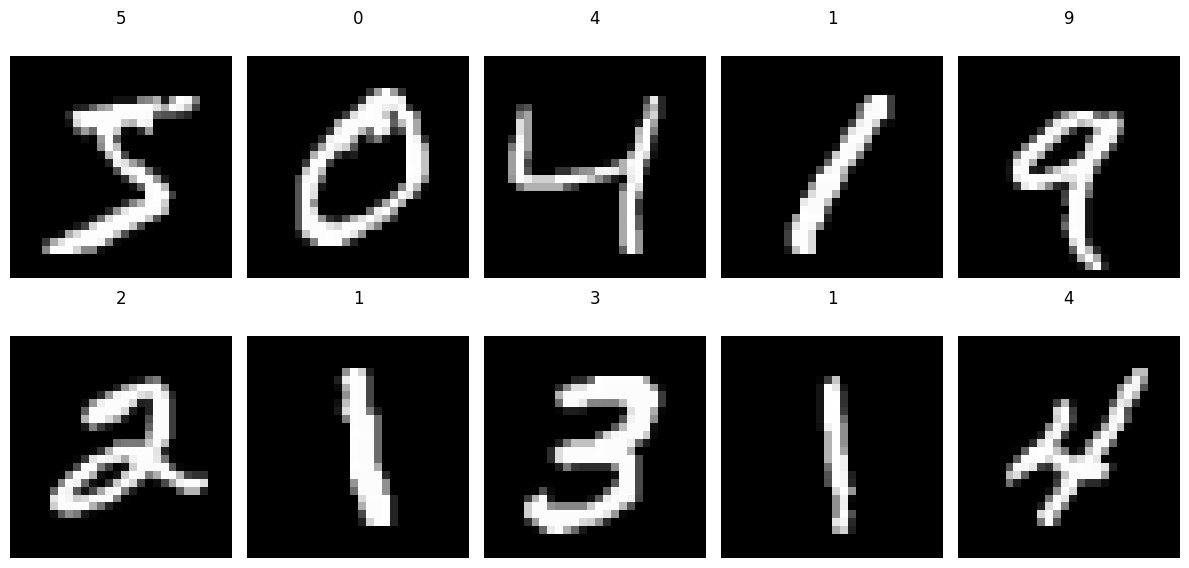

In [12]:
fig, axs = plt.subplots(2,5, sharey = False, tight_layout = True, figsize = (12,6), facecolor = 'white')

k = 0
for i in range(2) :
    for j in range(5) :
        axs[i,j].matshow(X_train[k],cmap = 'gray')
        axs[i,j].set(title = y_train[k])
        axs[i,j].axis('off')
        k+=1

plt.show()

In [13]:
data = X_train.copy()
data=data.reshape(X_train.shape[0], 28, 28, 1)
data = (data - 127.5) / 127.5 
print("Scaled array shape : ", data.shape)

Scaled array shape :  (60000, 28, 28, 1)


Generator

In [14]:
def generator(latent_dim, in_shape = (7,7,1), n_cats = 10) :
    in_label = Input(shape=(1,), name='Generator-Label-Input-Layer') 
    lbls = Embedding(n_cats, 50, name='Generator-Label-Embedding-Layer')(in_label) 
    
    
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls) 

    
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    
    
    n_nodes = 7 * 7 * 128 
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((in_shape[0], in_shape[1], 128), name='Generator-Foundation-Layer-Reshape-1')(g)
    
    
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)
    
    
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)
    
    
    output_layer = Conv2D(filters=1, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)

    
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

latent_dim=100 
gen_model = generator(latent_dim)

gen_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Generator-Latent-Input-Lay  [(None, 100)]                0         []                            
 er (InputLayer)                                                                                  
                                                                                                  
 Generator-Label-Input-Laye  [(None, 1)]                  0         []                            
 r (InputLayer)                                                                                   
                                                                                                  
 Generator-Foundation-Layer  (None, 6272)                 633472    ['Generator-Latent-Input-Layer
  (Dense)                                                           [0][0]']              

In [15]:
def discriminator(in_shape=(28,28,1), n_cats=10):
    
    in_label = Input(shape=(1,), name='Discriminator-Label-Input-Layer') 
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding-Layer')(in_label)
    
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls)

    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')
    
    concat = Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

    h = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)
    
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h)
    
    h = Flatten(name='Discriminator-Flatten-Layer')(h) 
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h)
   
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) 
    
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

dis_model = discriminator()

dis_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Discriminator-Label-Input-  [(None, 1)]                  0         []                            
 Layer (InputLayer)                                                                               
                                                                                                  
 Discriminator-Label-Embedd  (None, 1, 50)                500       ['Discriminator-Label-Input-La
 ing-Layer (Embedding)                                              yer[0][0]']                   
                                                                                                  
 Discriminator-Label-Dense-  (None, 1, 784)               39984     ['Discriminator-Label-Embeddin
 Layer (Dense)                                                      g-Layer[0][0]']   

In [16]:
def cgan(generator, discriminator):
    
    discriminator.trainable = False
    
    gen_latent, gen_label = generator.input 
    gen_output = generator.output 
    
    gan_output = discriminator([gen_output, gen_label])
    
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

gan_model = cgan(gen_model, dis_model)

gan_model.summary()


Model: "cDCGAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Generator-Latent-Input-Lay  [(None, 100)]                0         []                            


 er (InputLayer)                                                                                  
                                                                                                  
 Generator-Label-Input-Laye  [(None, 1)]                  0         []                            
 r (InputLayer)                                                                                   
                                                                                                  
 Generator-Foundation-Layer  (None, 6272)                 633472    ['Generator-Latent-Input-Layer
  (Dense)                                                           [0][0]']                      
                                                                                                  
 Generator-Label-Embedding-  (None, 1, 50)                500       ['Generator-Label-Input-Layer[
 Layer (Embedding)                                                  0][0]']                       
          

In [13]:
def real_samples(dataset, categories, n):
    
    indx = np.random.randint(0, dataset.shape[0], n)
    
    X, cat_labels = dataset[indx], categories[indx]

    y = np.ones((n, 1))
    return [X, cat_labels], y
    
    
def latent_vector(latent_dim, n, n_cats=10):
    
    latent_input = np.random.randn(latent_dim * n)
    
    latent_input = latent_input.reshape(n, latent_dim)
    
    cat_labels = np.random.randint(0, n_cats, n)
    return [latent_input, cat_labels] 
  
  
def fake_samples(generator, latent_dim, n):
    
    latent_output, cat_labels = latent_vector(latent_dim, n)
    
    X = generator.predict([latent_output, cat_labels])
    
    y = np.zeros((n, 1))
    return [X, cat_labels], y


In [11]:
def show_fakes(generator, latent_dim, n=10):
    
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    X_tst = (x_fake[0] + 1) / 2.0
    
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show() 

In [19]:
def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=10, n_batch=128, n_eval=200):
    
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        for j in range(batch_per_epoch):
    
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)

 batch_per_epoch:  468
2/2 [==============================] - 0s 15ms/step
Epoch: 1, Batch: 1/468, D_Loss_Real=0.706, D_Loss_Fake=0.696 Gen_Loss=0.691
1/1 [==============================] - 0s 48ms/step


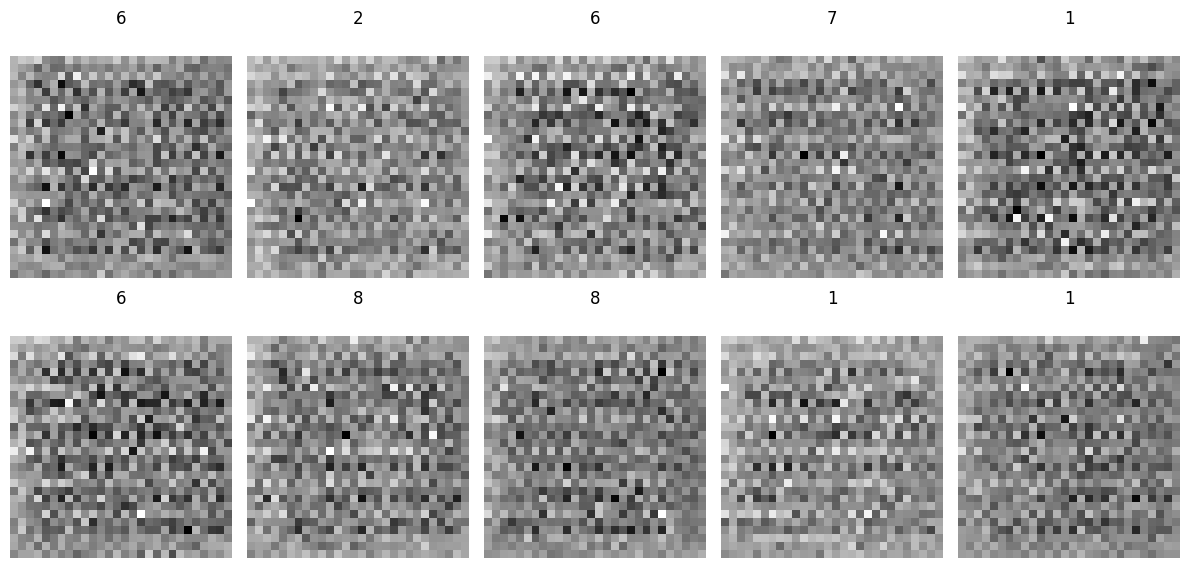

2/2 [==============================] - 0s 15ms/step
Epoch: 1, Batch: 201/468, D_Loss_Real=0.603, D_Loss_Fake=0.642 Gen_Loss=0.885
1/1 [==============================] - 0s 12ms/step


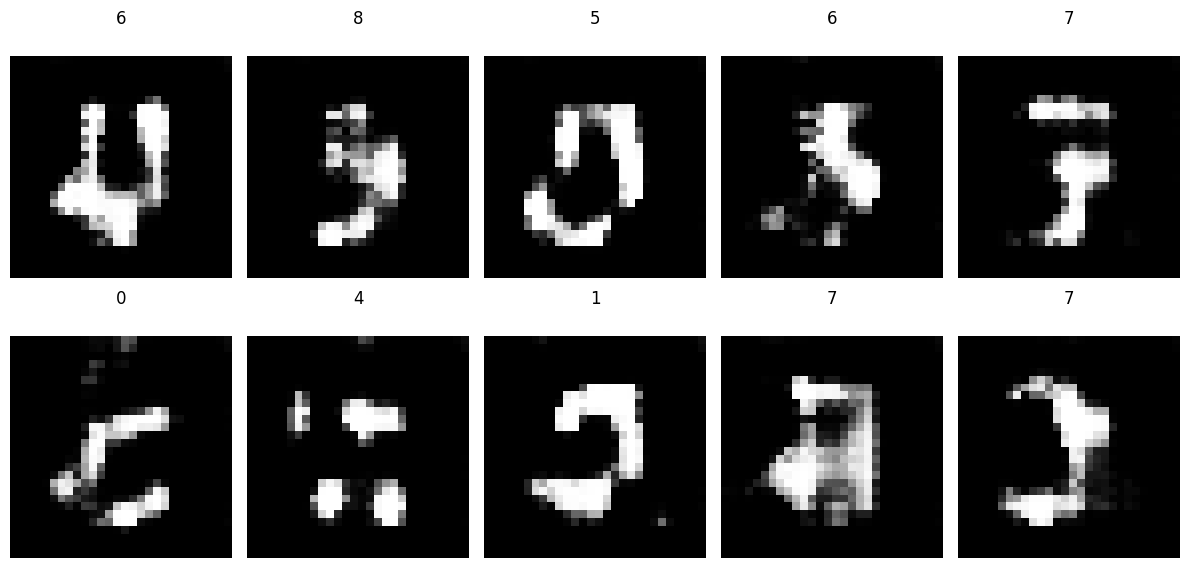

2/2 [==============================] - 0s 15ms/step
Epoch: 1, Batch: 401/468, D_Loss_Real=0.667, D_Loss_Fake=0.665 Gen_Loss=0.801
1/1 [==============================] - 0s 13ms/step


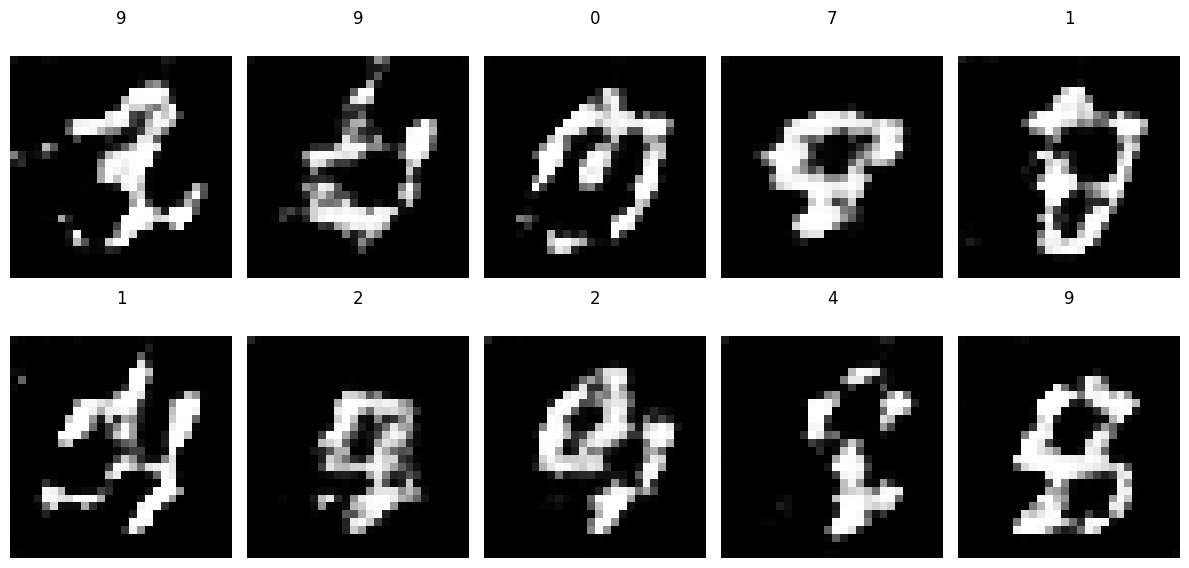

2/2 [==============================] - 0s 15ms/step
Epoch: 2, Batch: 1/468, D_Loss_Real=0.641, D_Loss_Fake=0.645 Gen_Loss=0.797
1/1 [==============================] - 0s 13ms/step


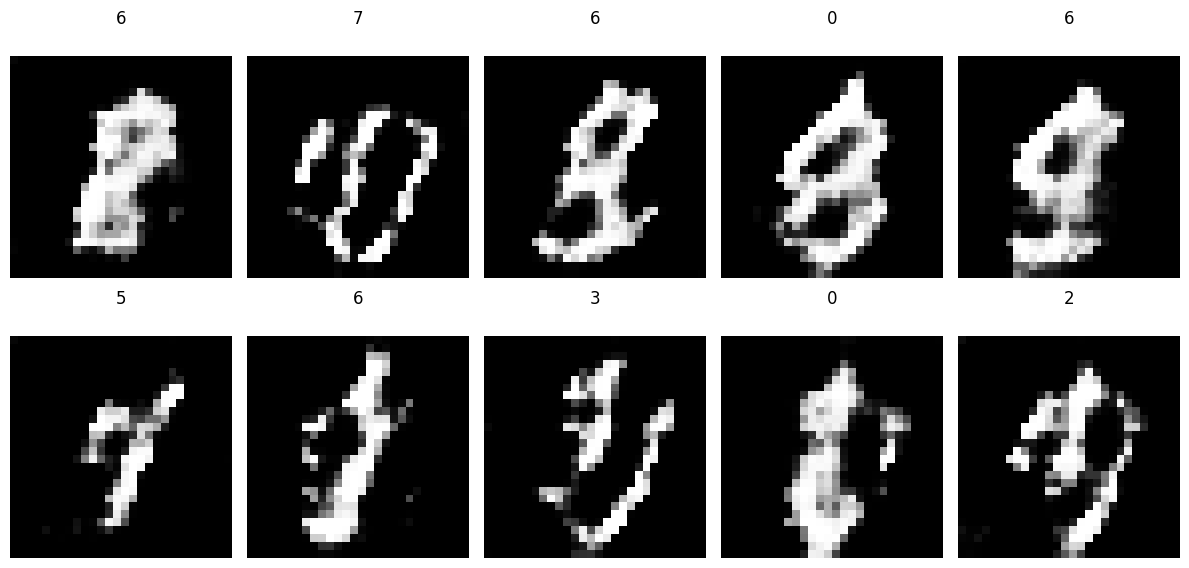

2/2 [==============================] - 0s 16ms/step
Epoch: 2, Batch: 201/468, D_Loss_Real=0.674, D_Loss_Fake=0.651 Gen_Loss=0.774
1/1 [==============================] - 0s 14ms/step


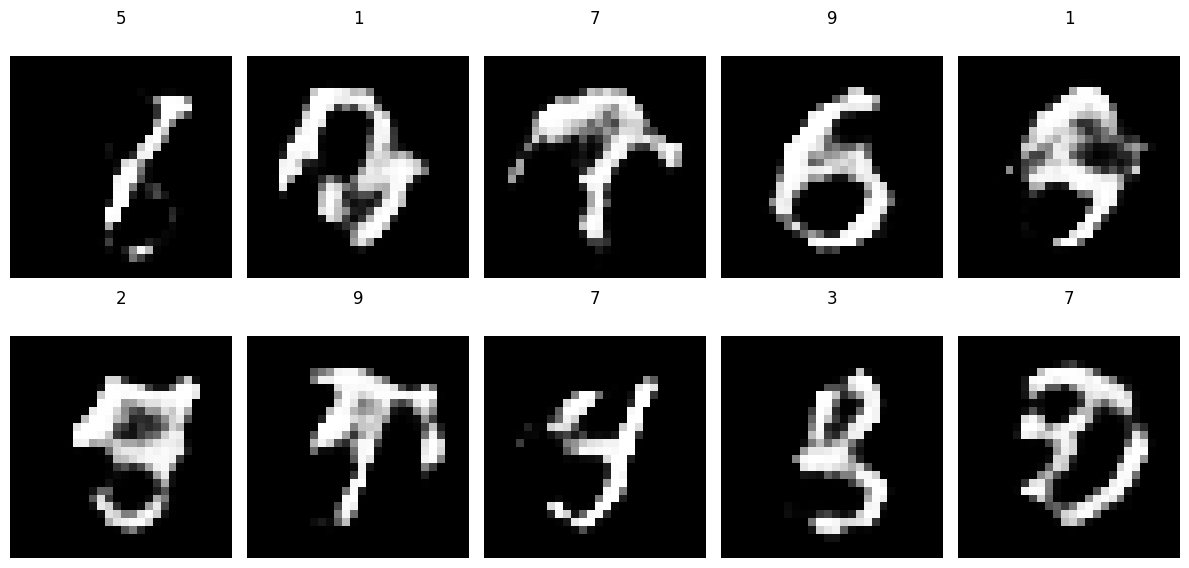

2/2 [==============================] - 0s 16ms/step
Epoch: 2, Batch: 401/468, D_Loss_Real=0.617, D_Loss_Fake=0.642 Gen_Loss=0.820
1/1 [==============================] - 0s 15ms/step


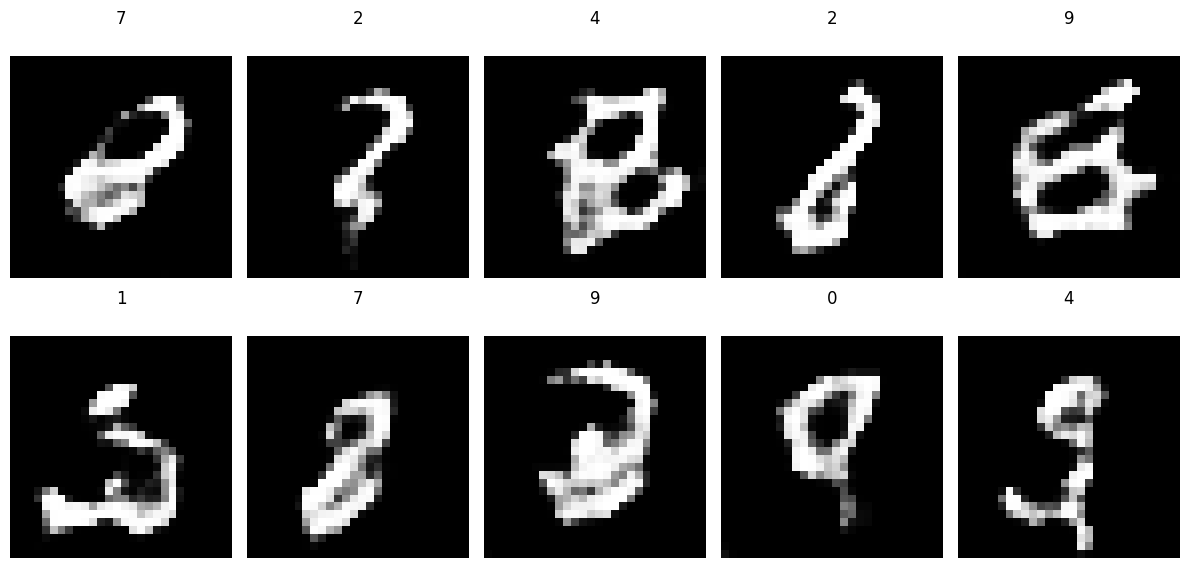

2/2 [==============================] - 0s 19ms/step
Epoch: 3, Batch: 1/468, D_Loss_Real=0.608, D_Loss_Fake=0.587 Gen_Loss=0.840
1/1 [==============================] - 0s 15ms/step


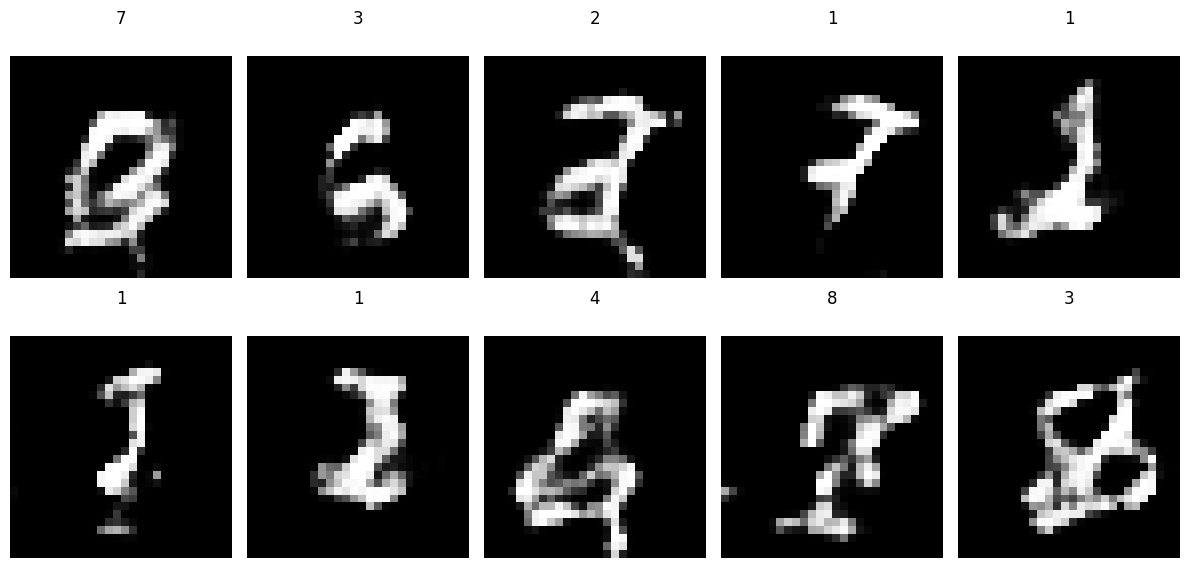

2/2 [==============================] - 0s 17ms/step
Epoch: 3, Batch: 201/468, D_Loss_Real=0.677, D_Loss_Fake=0.663 Gen_Loss=0.750
1/1 [==============================] - 0s 15ms/step


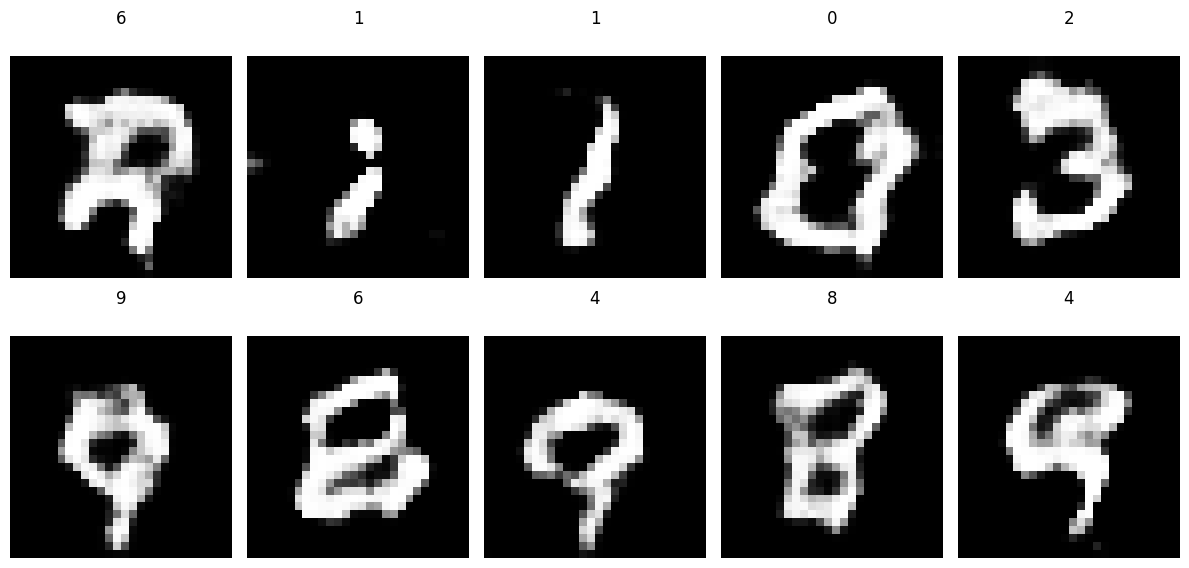

2/2 [==============================] - 0s 17ms/step
Epoch: 3, Batch: 401/468, D_Loss_Real=0.672, D_Loss_Fake=0.648 Gen_Loss=0.750
1/1 [==============================] - 0s 15ms/step


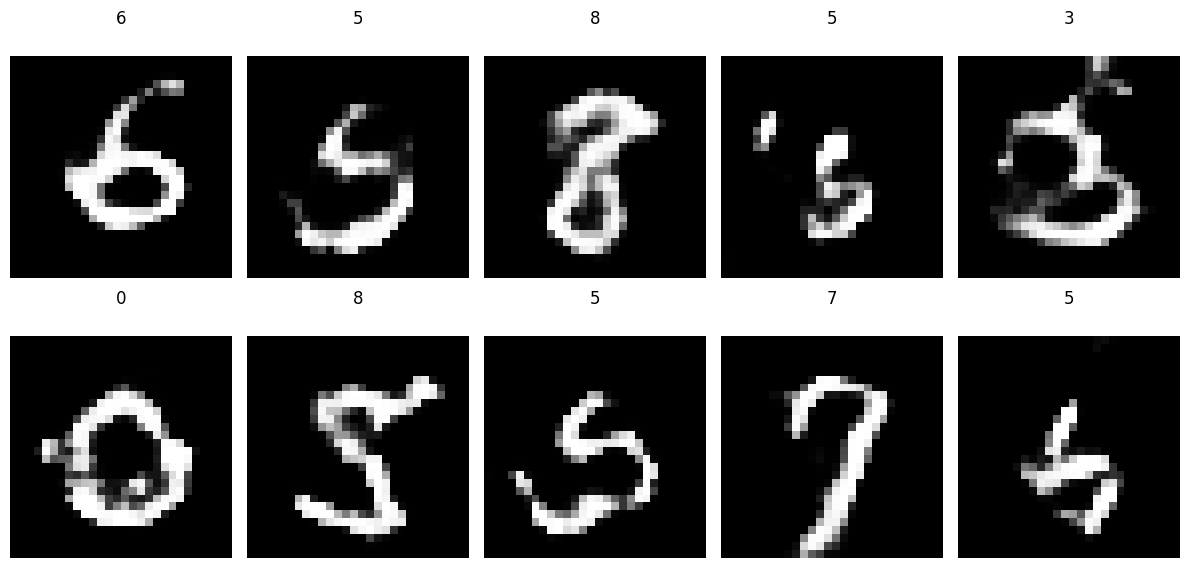

2/2 [==============================] - 0s 16ms/step
Epoch: 4, Batch: 1/468, D_Loss_Real=0.675, D_Loss_Fake=0.666 Gen_Loss=0.751
1/1 [==============================] - 0s 15ms/step


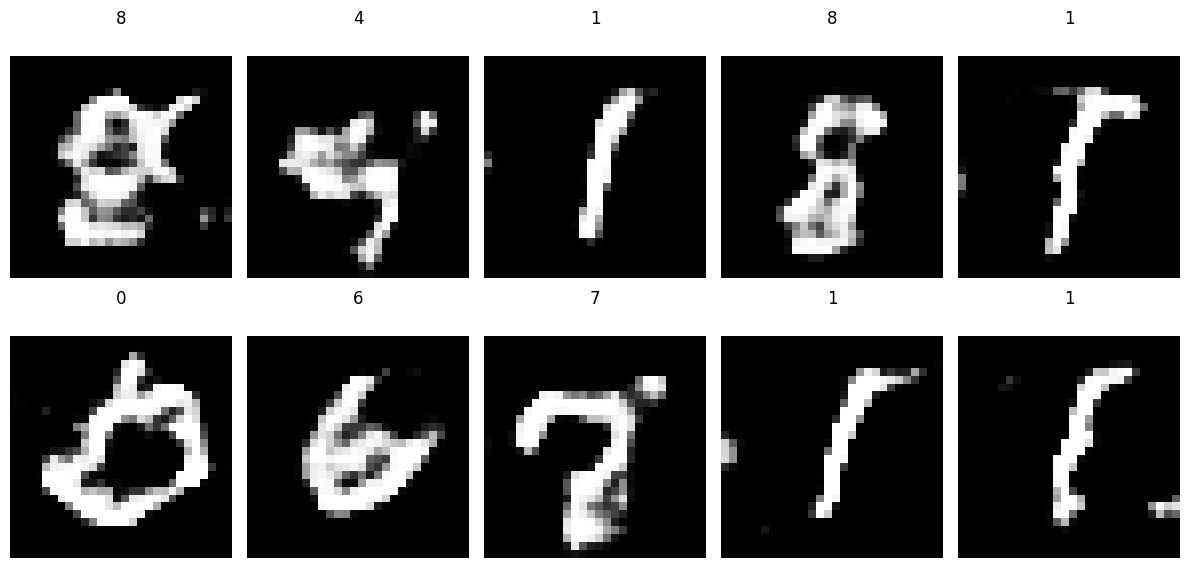

2/2 [==============================] - 0s 18ms/step
Epoch: 4, Batch: 201/468, D_Loss_Real=0.654, D_Loss_Fake=0.701 Gen_Loss=0.746
1/1 [==============================] - 0s 16ms/step


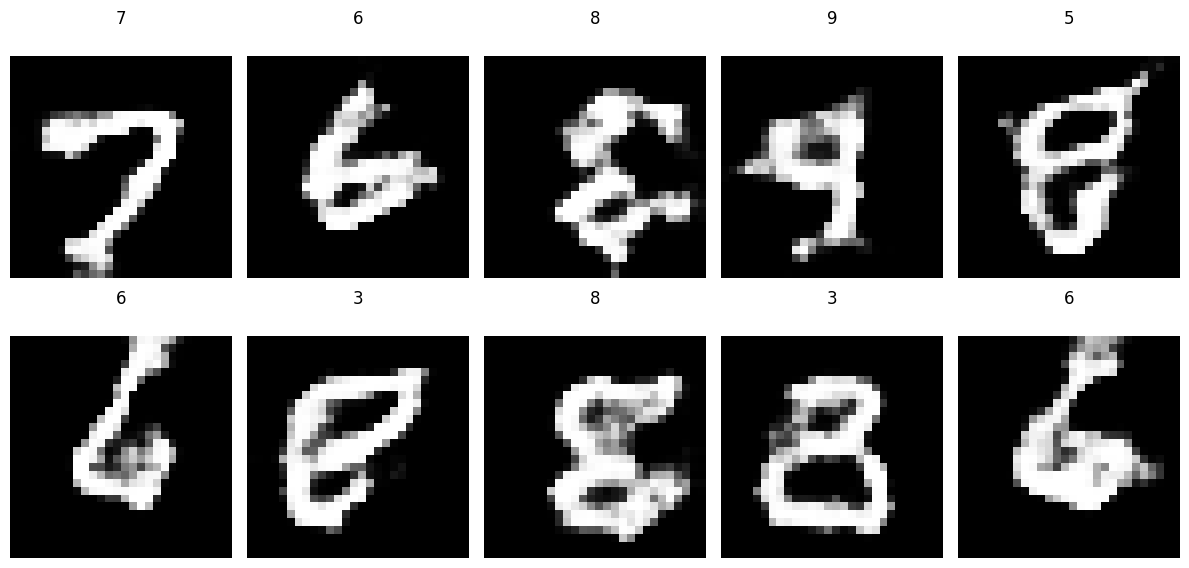

2/2 [==============================] - 0s 16ms/step
Epoch: 4, Batch: 401/468, D_Loss_Real=0.673, D_Loss_Fake=0.682 Gen_Loss=0.758
1/1 [==============================] - 0s 16ms/step


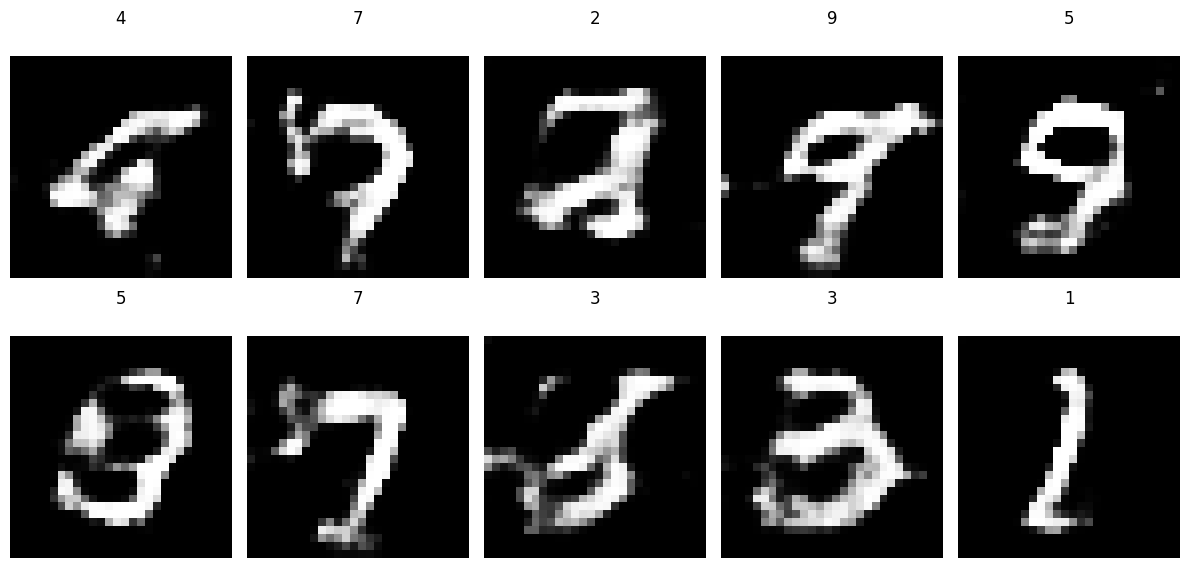

2/2 [==============================] - 0s 17ms/step
Epoch: 5, Batch: 1/468, D_Loss_Real=0.672, D_Loss_Fake=0.715 Gen_Loss=0.746
1/1 [==============================] - 0s 16ms/step


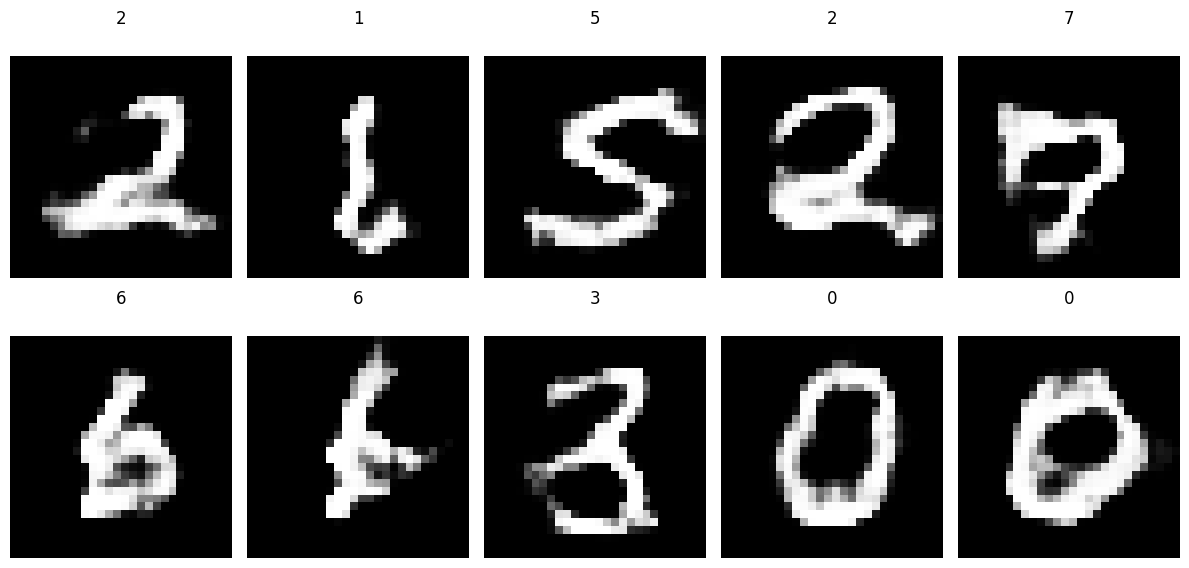

2/2 [==============================] - 0s 18ms/step
Epoch: 5, Batch: 201/468, D_Loss_Real=0.667, D_Loss_Fake=0.643 Gen_Loss=0.760
1/1 [==============================] - 0s 15ms/step


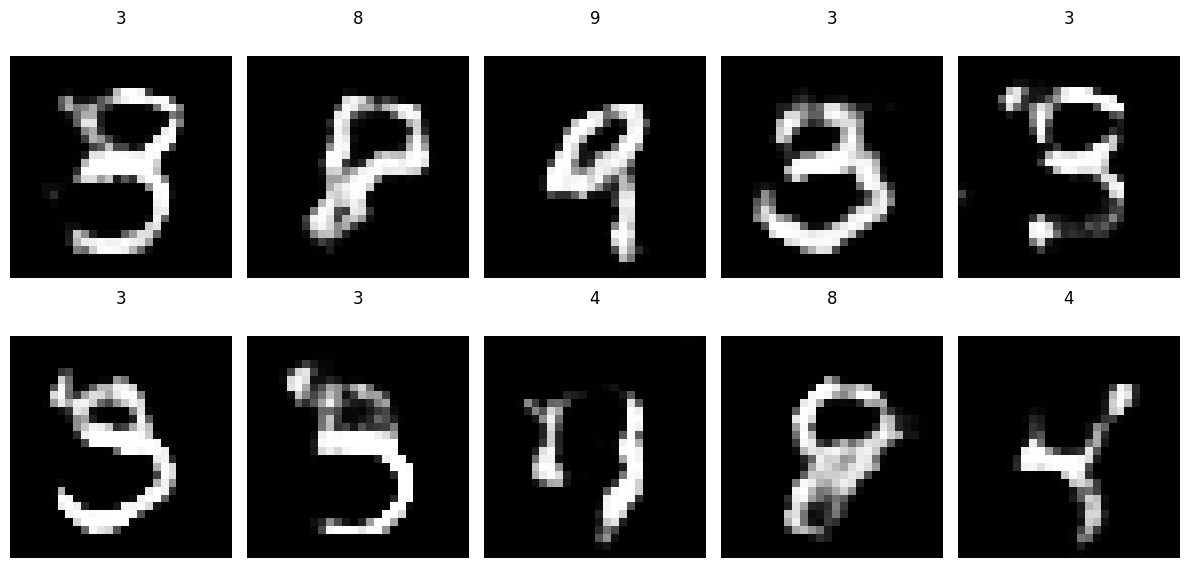

2/2 [==============================] - 0s 19ms/step
Epoch: 5, Batch: 401/468, D_Loss_Real=0.707, D_Loss_Fake=0.675 Gen_Loss=0.753
1/1 [==============================] - 0s 16ms/step


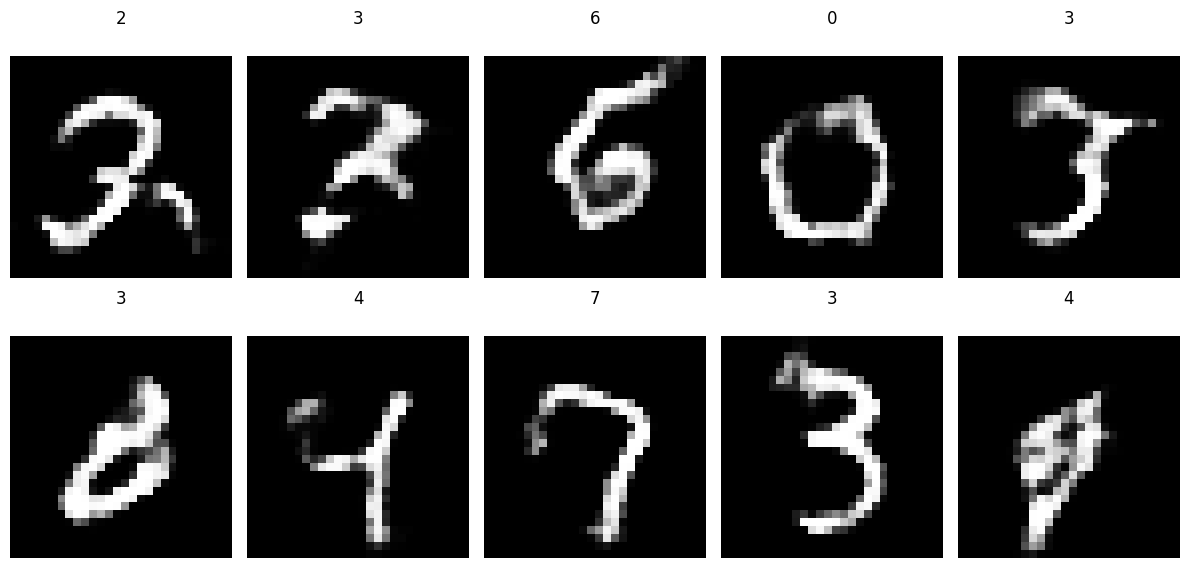

2/2 [==============================] - 0s 17ms/step
Epoch: 6, Batch: 1/468, D_Loss_Real=0.680, D_Loss_Fake=0.680 Gen_Loss=0.751
1/1 [==============================] - 0s 19ms/step


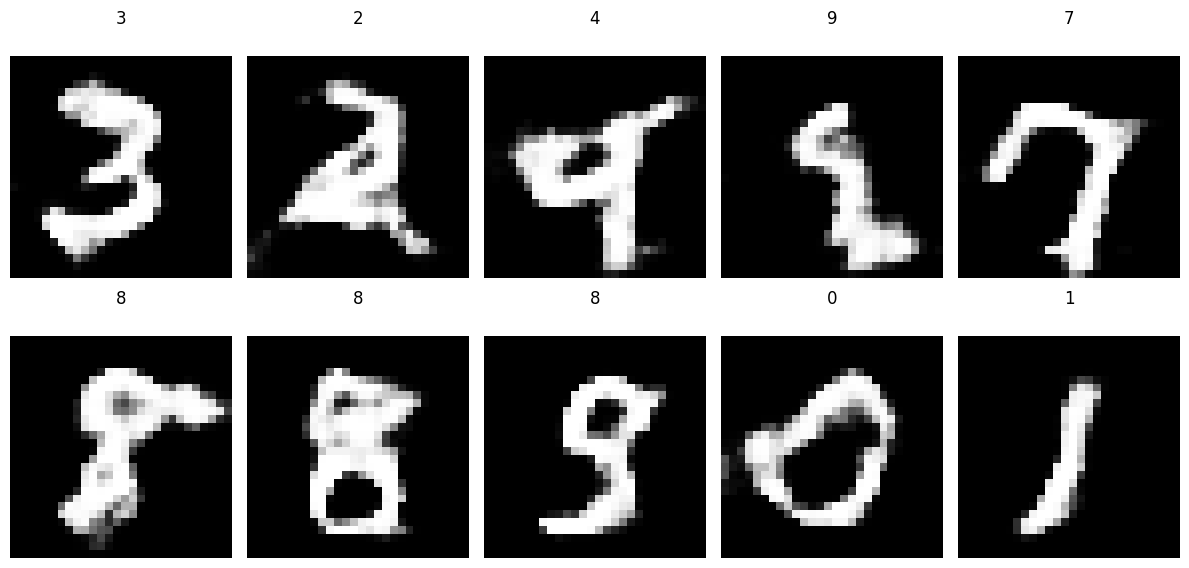

2/2 [==============================] - 0s 18ms/step
Epoch: 6, Batch: 201/468, D_Loss_Real=0.654, D_Loss_Fake=0.687 Gen_Loss=0.750
1/1 [==============================] - 0s 17ms/step


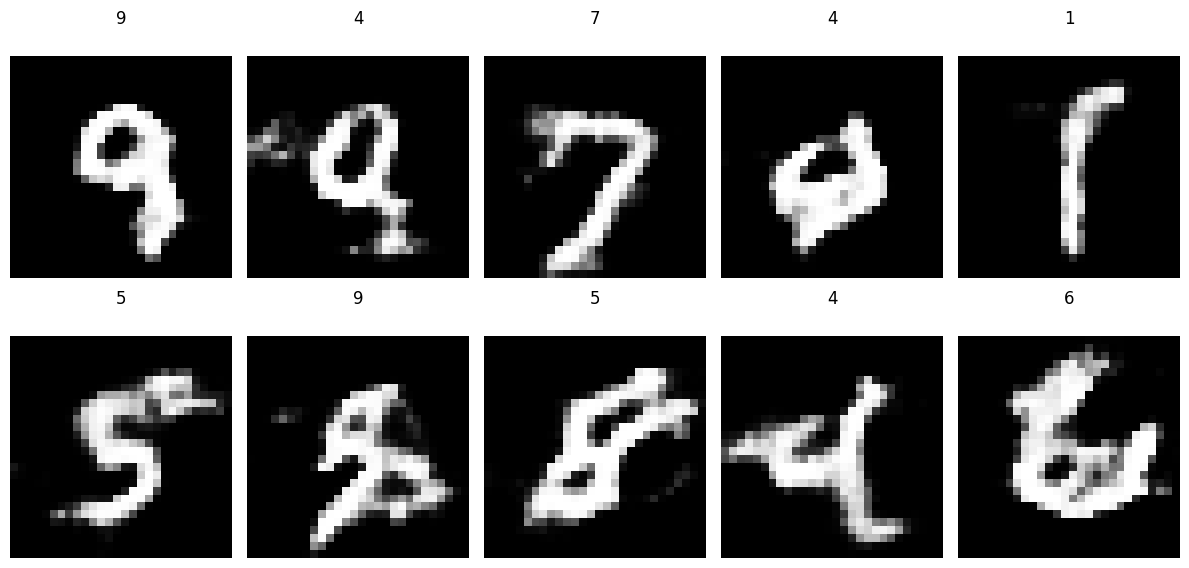

2/2 [==============================] - 0s 17ms/step
Epoch: 6, Batch: 401/468, D_Loss_Real=0.683, D_Loss_Fake=0.678 Gen_Loss=0.749
1/1 [==============================] - 0s 15ms/step


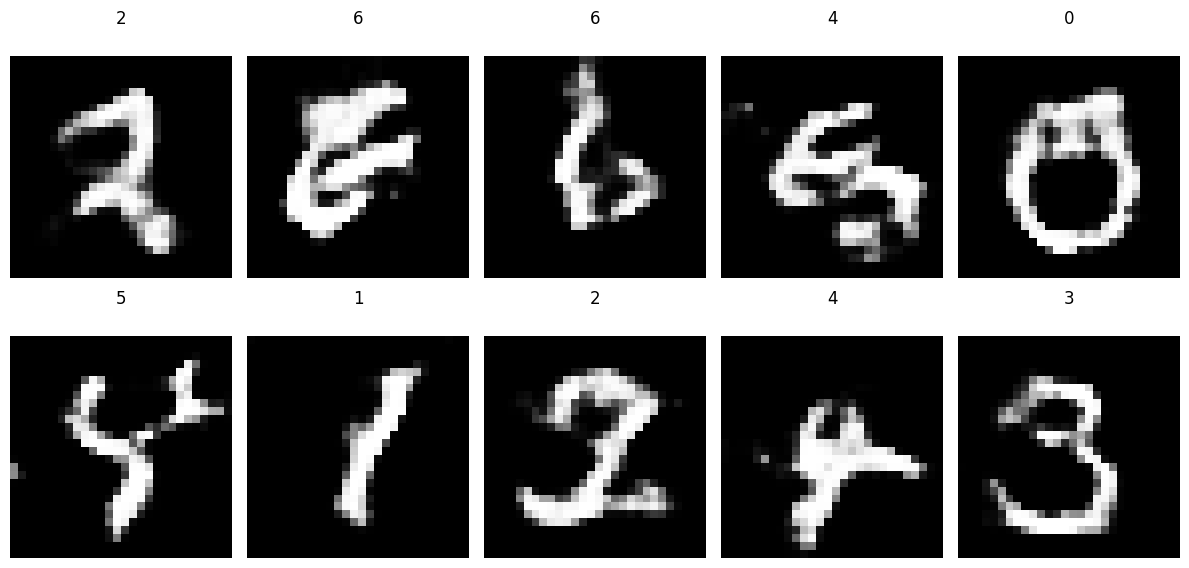

2/2 [==============================] - 0s 18ms/step
Epoch: 7, Batch: 1/468, D_Loss_Real=0.648, D_Loss_Fake=0.653 Gen_Loss=0.749
1/1 [==============================] - 0s 16ms/step


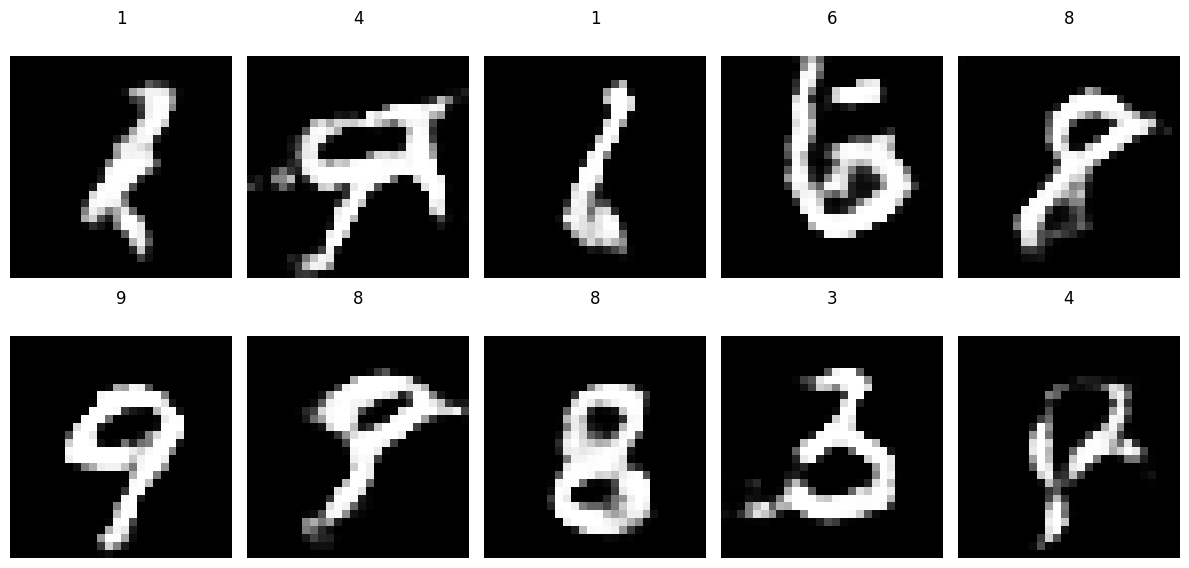

2/2 [==============================] - 0s 16ms/step
Epoch: 7, Batch: 201/468, D_Loss_Real=0.670, D_Loss_Fake=0.695 Gen_Loss=0.752
1/1 [==============================] - 0s 14ms/step


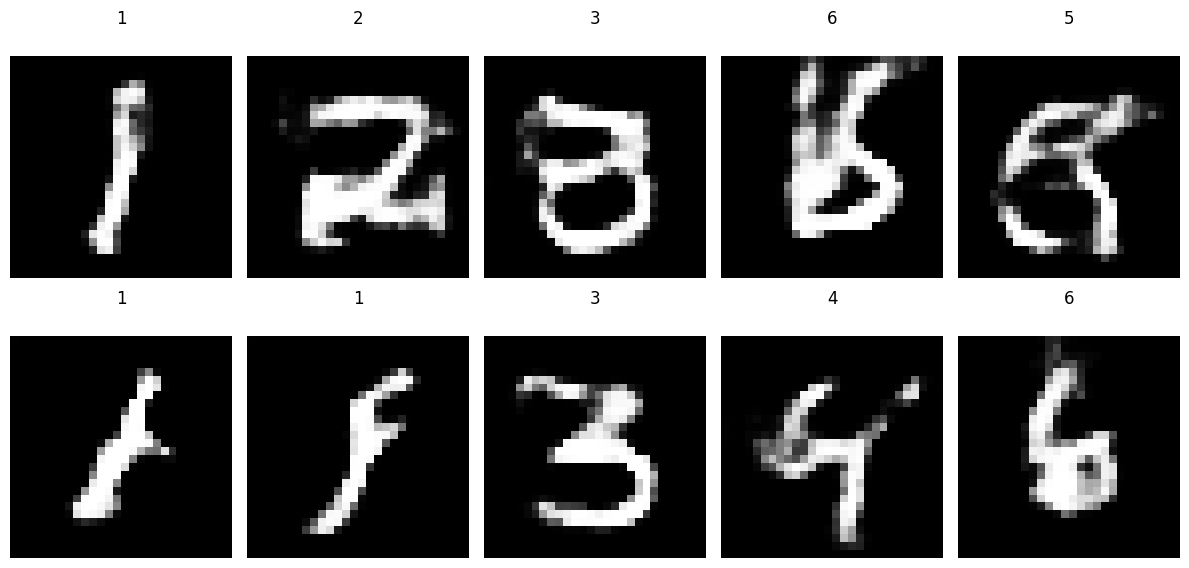

2/2 [==============================] - 0s 18ms/step
Epoch: 7, Batch: 401/468, D_Loss_Real=0.677, D_Loss_Fake=0.690 Gen_Loss=0.767
1/1 [==============================] - 0s 15ms/step


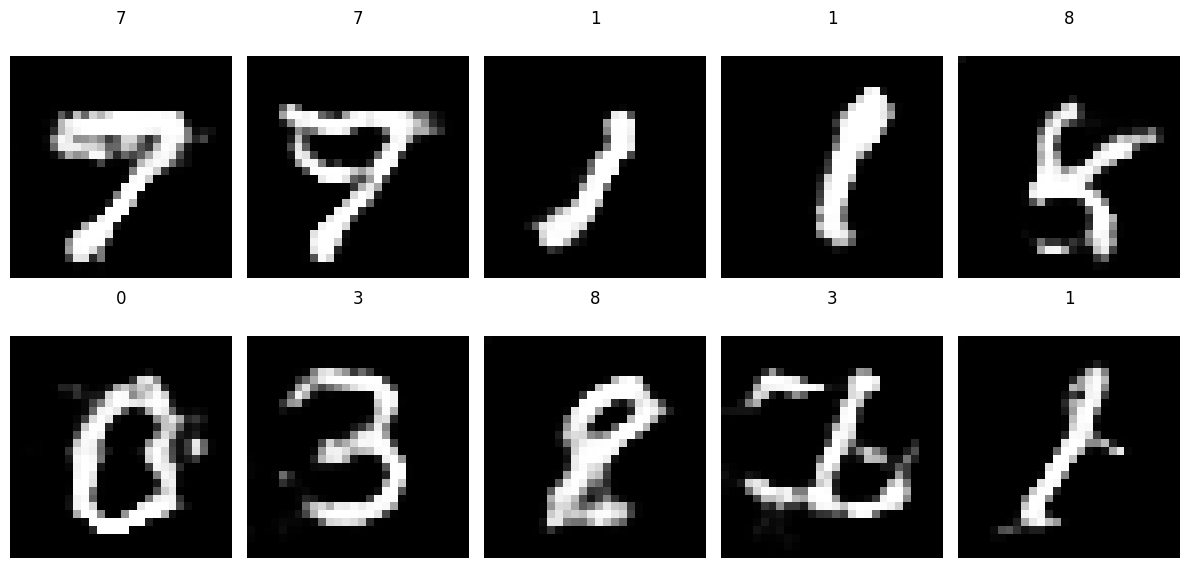

2/2 [==============================] - 0s 16ms/step
Epoch: 8, Batch: 1/468, D_Loss_Real=0.686, D_Loss_Fake=0.609 Gen_Loss=0.792
1/1 [==============================] - 0s 14ms/step


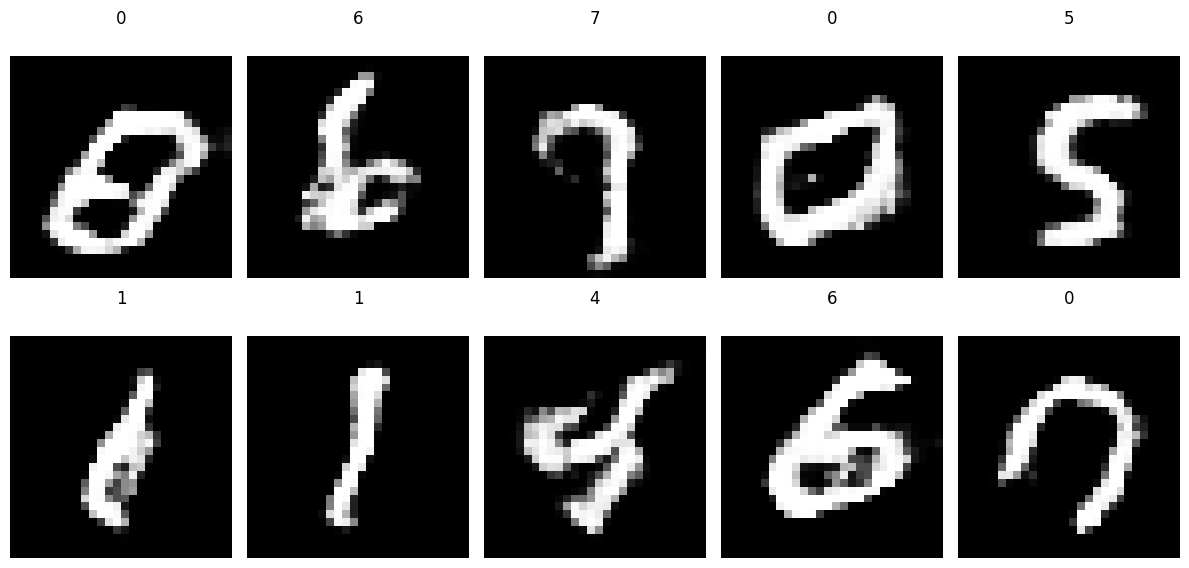

2/2 [==============================] - 0s 16ms/step
Epoch: 8, Batch: 201/468, D_Loss_Real=0.678, D_Loss_Fake=0.670 Gen_Loss=0.725
1/1 [==============================] - 0s 17ms/step


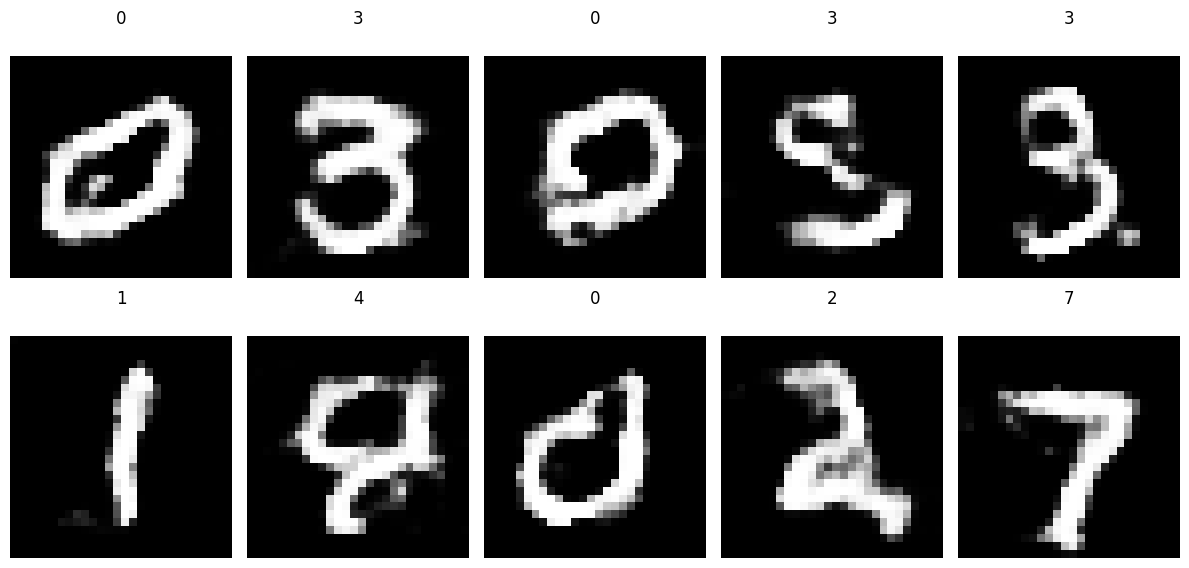

2/2 [==============================] - 0s 17ms/step
Epoch: 8, Batch: 401/468, D_Loss_Real=0.673, D_Loss_Fake=0.670 Gen_Loss=0.749
1/1 [==============================] - 0s 18ms/step


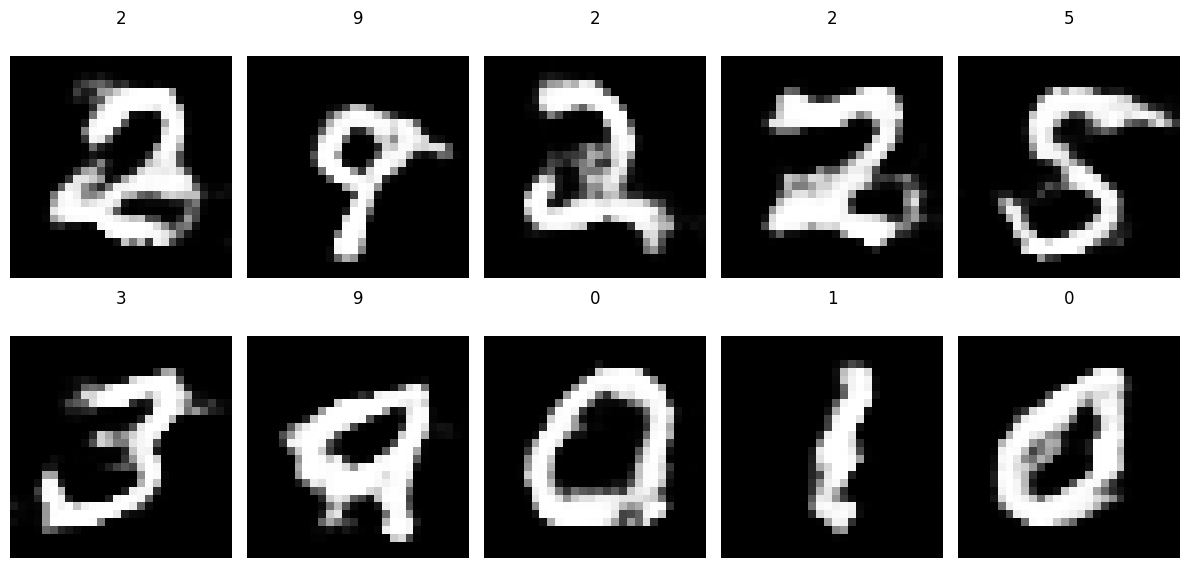

2/2 [==============================] - 0s 19ms/step
Epoch: 9, Batch: 1/468, D_Loss_Real=0.694, D_Loss_Fake=0.678 Gen_Loss=0.731
1/1 [==============================] - 0s 17ms/step


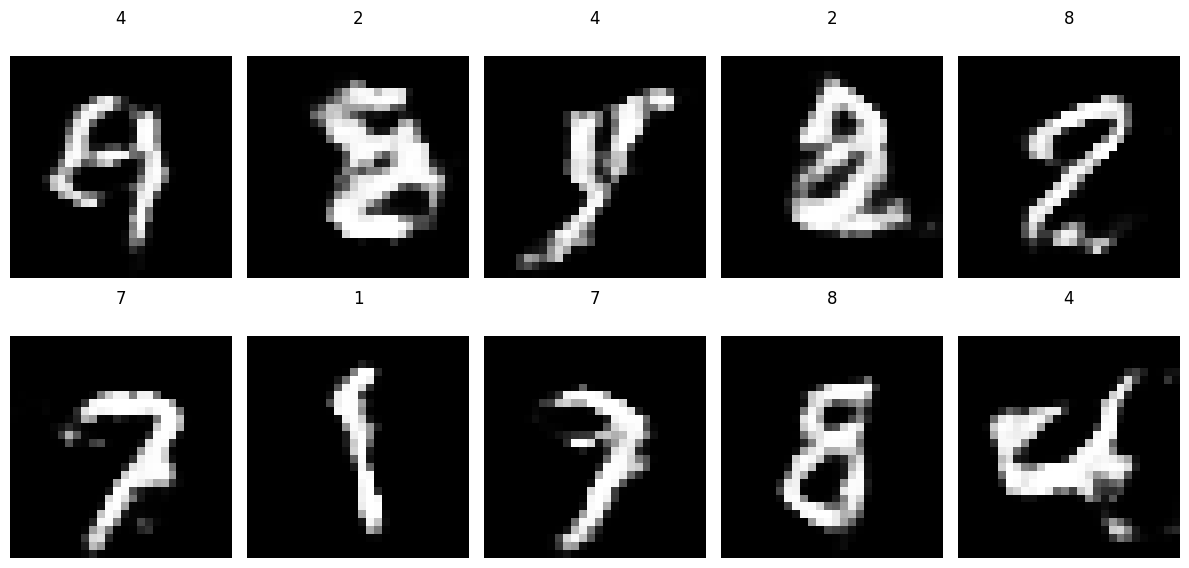

2/2 [==============================] - 0s 16ms/step
Epoch: 9, Batch: 201/468, D_Loss_Real=0.685, D_Loss_Fake=0.702 Gen_Loss=0.743
1/1 [==============================] - 0s 18ms/step


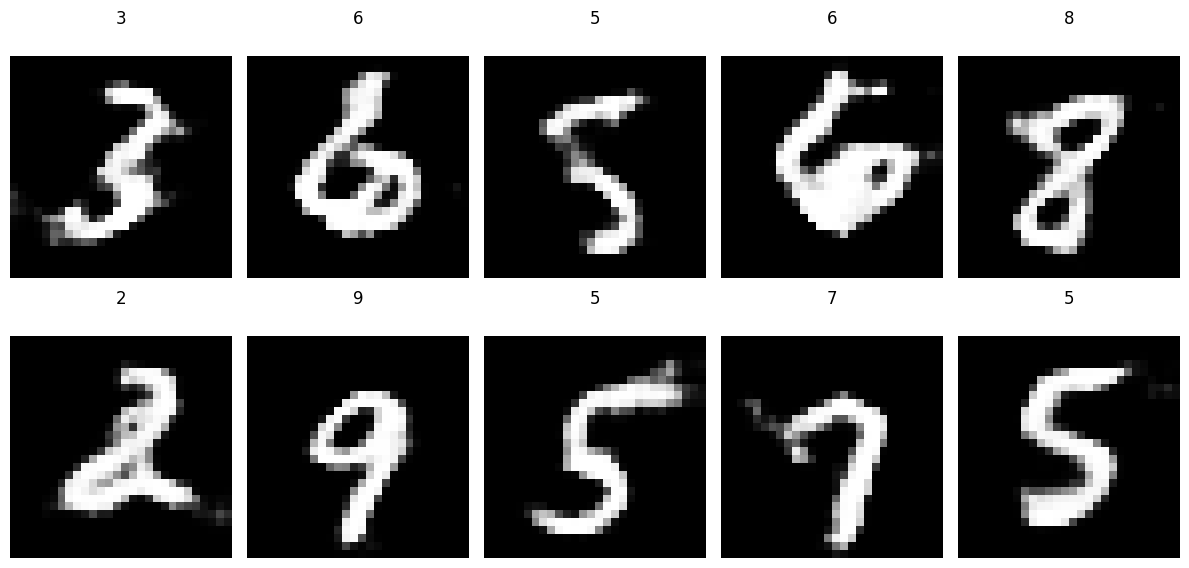

2/2 [==============================] - 0s 18ms/step
Epoch: 9, Batch: 401/468, D_Loss_Real=0.687, D_Loss_Fake=0.687 Gen_Loss=0.743
1/1 [==============================] - 0s 16ms/step


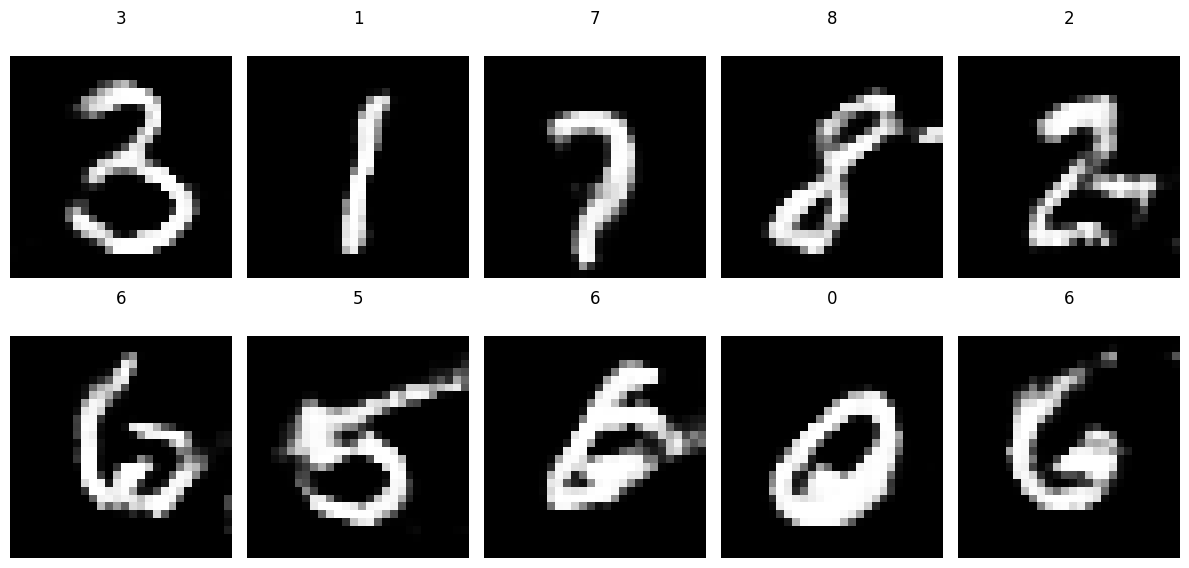

2/2 [==============================] - 0s 20ms/step
Epoch: 10, Batch: 1/468, D_Loss_Real=0.701, D_Loss_Fake=0.676 Gen_Loss=0.728
1/1 [==============================] - 0s 17ms/step


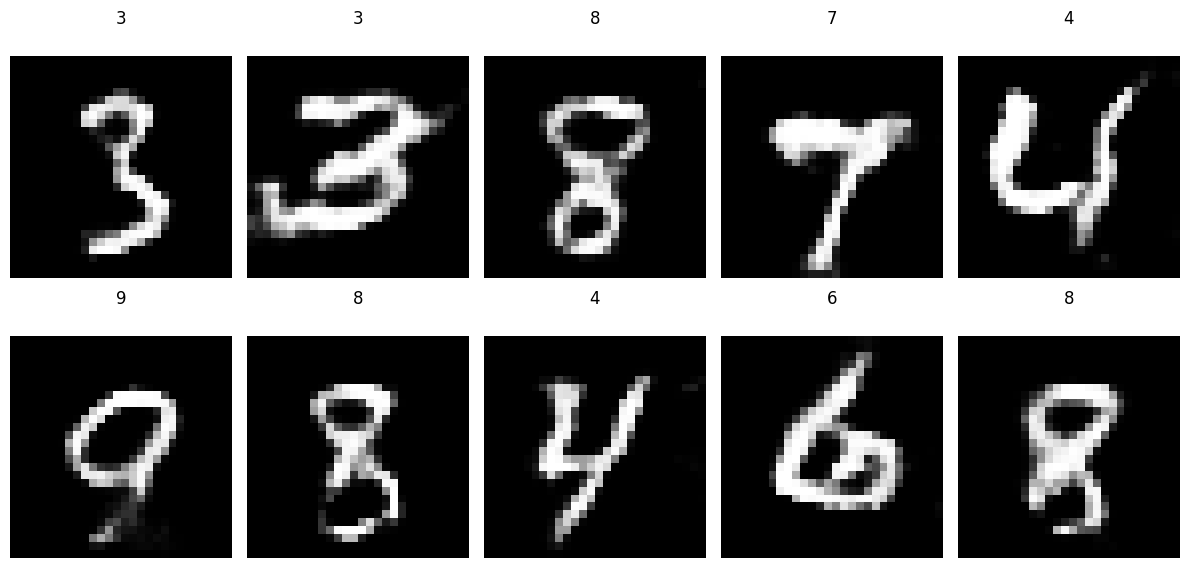

2/2 [==============================] - 0s 16ms/step
Epoch: 10, Batch: 201/468, D_Loss_Real=0.690, D_Loss_Fake=0.695 Gen_Loss=0.757
1/1 [==============================] - 0s 17ms/step


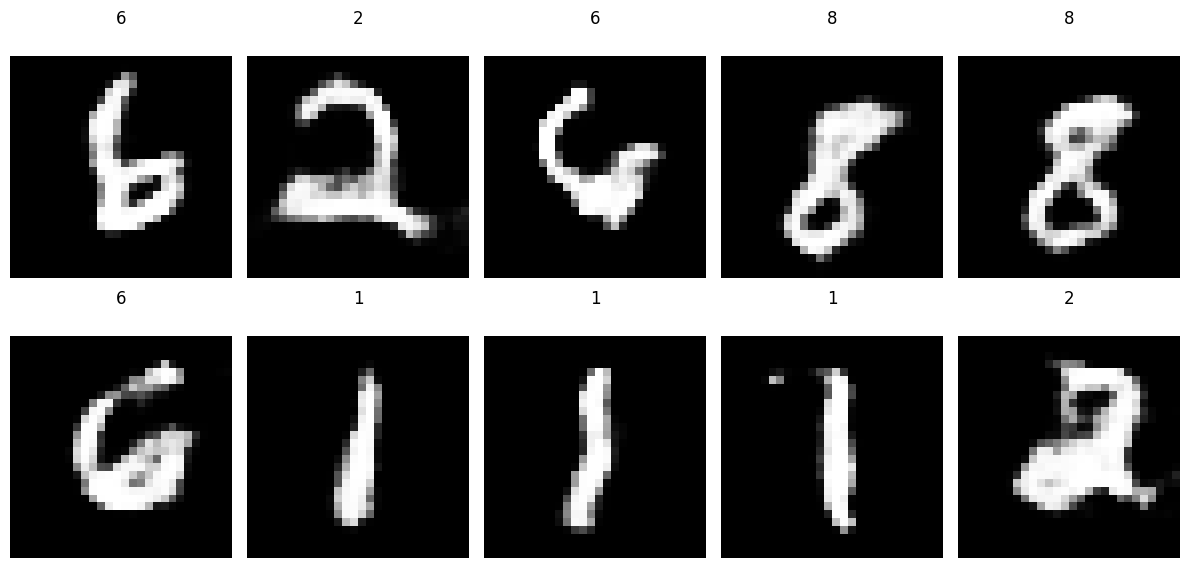

2/2 [==============================] - 0s 16ms/step
Epoch: 10, Batch: 401/468, D_Loss_Real=0.684, D_Loss_Fake=0.676 Gen_Loss=0.740
1/1 [==============================] - 0s 17ms/step


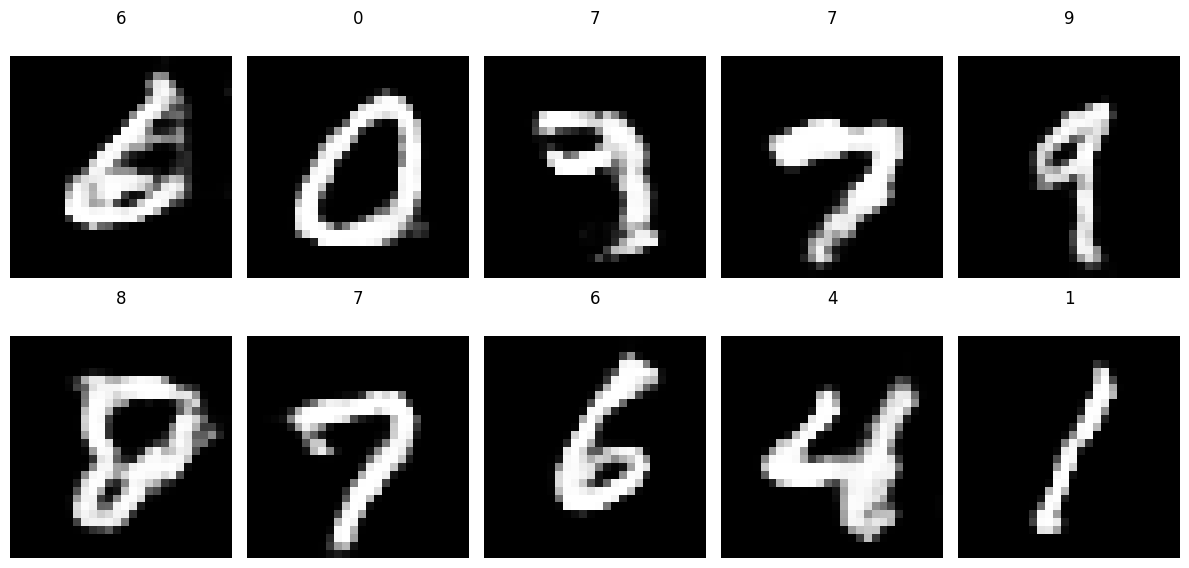

2/2 [==============================] - 0s 19ms/step


In [20]:
train(gen_model, dis_model, gan_model, data, y_train, latent_dim)

In [21]:
gen_model.save('cGAN.keras')

1/1 [==============================] - 0s 44ms/step


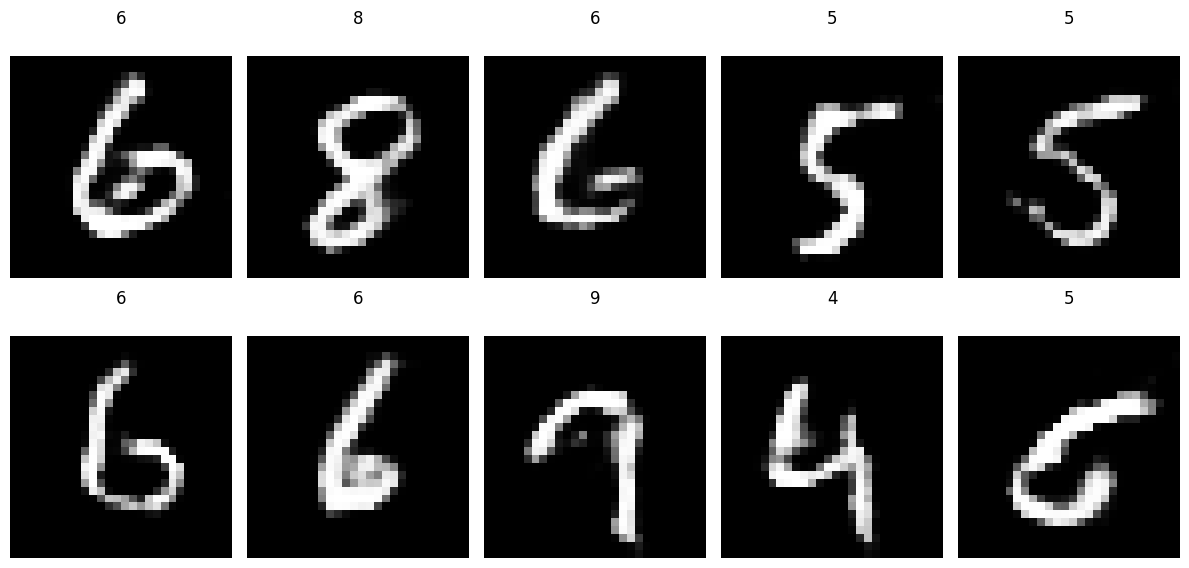

1/1 [==============================] - 0s 13ms/step


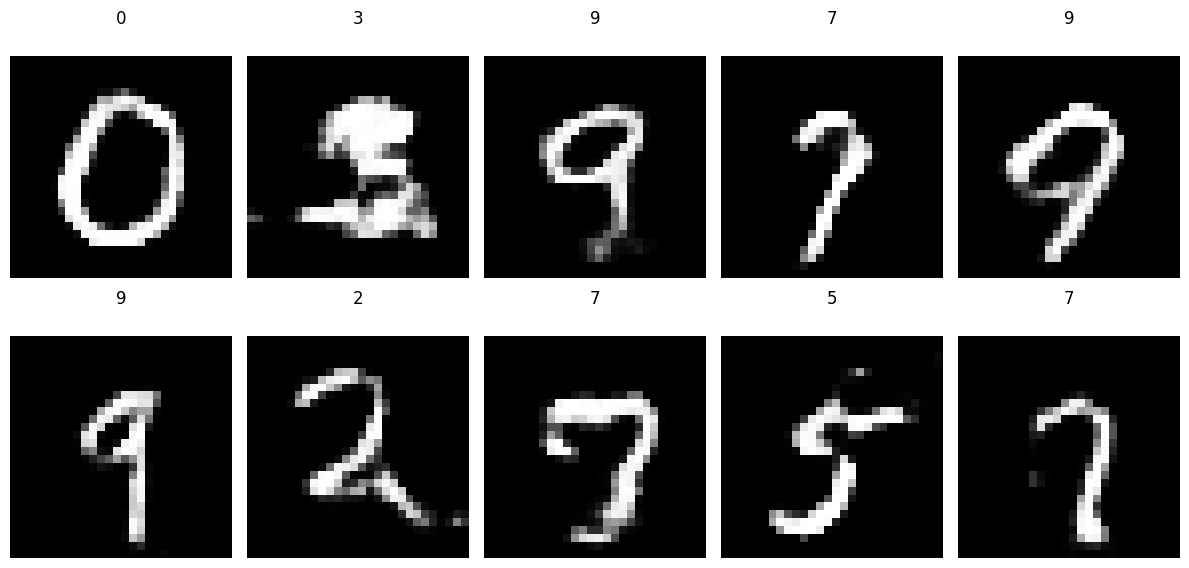

1/1 [==============================] - 0s 13ms/step


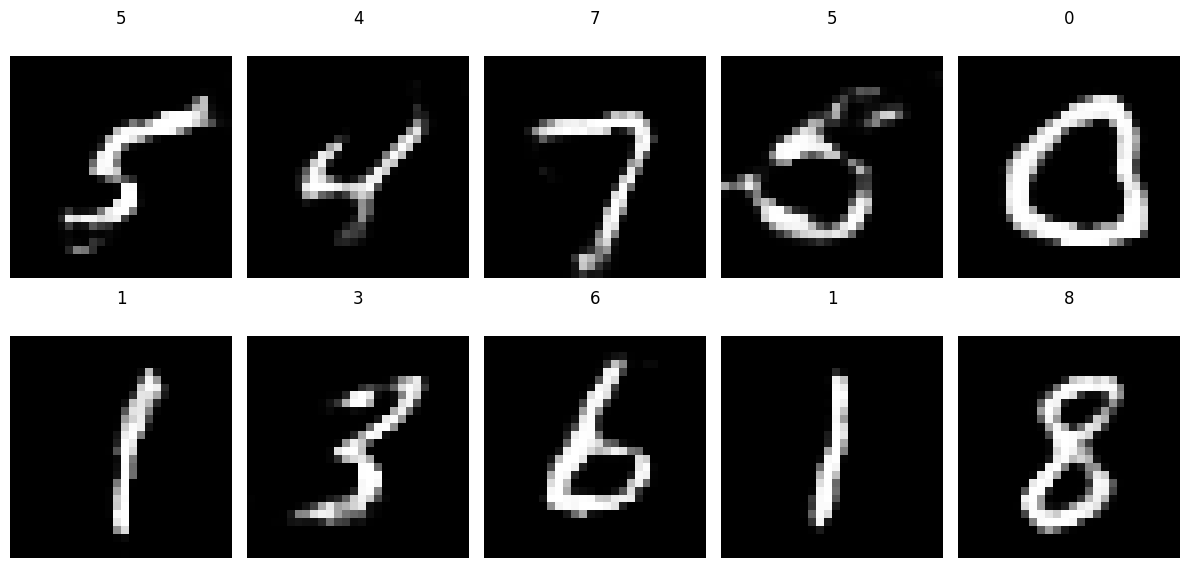

In [15]:
from keras.models import load_model

gen_model = load_model('./cGAN.keras')
show_fakes(gen_model, latent_dim=100)
show_fakes(gen_model, latent_dim=100)
show_fakes(gen_model, latent_dim=100)